# Variational Autoencoder (VAE) Training - Multi-Category

Trains a VAE for each MVTec AD category with **KL annealing** to prevent KL explosion.

**Key Features:**
- Probabilistic latent space
- KL warmup (beta annealing) to stabilize training
- Latent space visualization

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0, 'F:/Thesis')

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

from src.config import DEVICE, MODELS_DIR, FIGURES_DIR, MVTEC_CATEGORIES, OUTPUTS_DIR, ensure_dirs
from src.data import create_mvtec_dataloaders
from src.models import create_vae
from src.training import get_optimizer, get_scheduler, EarlyStopping
from src.evaluation import plot_training_curves

ensure_dirs()
print(f"Device: {DEVICE}")

Device: cpu


## Configuration

In [ ]:
CONFIG = {
    'batch_size': 16,
    'num_epochs': 50,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'latent_dim': 128,
    'beta_max': 0.001,  # Final KL weight (very small to prioritize reconstruction)
    'beta_warmup_epochs': 10,  # Epochs to linearly increase beta from 0 to beta_max
    'patience': 5,
    'save_every': 10,
}

# Select categories to train
CATEGORIES_TO_TRAIN = MVTEC_CATEGORIES
# CATEGORIES_TO_TRAIN = ['bottle']  # Uncomment for testing

print(f"Categories to train: {len(CATEGORIES_TO_TRAIN)}")
print(f"Beta max: {CONFIG['beta_max']} (with {CONFIG['beta_warmup_epochs']} epoch warmup)")

Categories to train: 15
Beta max: 0.001 (with 10 epoch warmup)


## Training Function with KL Annealing

In [ ]:
def train_vae_category(category):
    print(f"\n{'='*50}")
    print(f"Training VAE: {category.upper()}")
    print(f"{'='*50}")
    
    # 1. Load Data
    try:
        train_loader, test_loader = create_mvtec_dataloaders(
            category, batch_size=CONFIG['batch_size'], return_mask=True
        )
    except Exception as e:
        print(f"Skipping {category}: {e}")
        return None
    
    # 2. Create Model
    model = create_vae(latent_dim=CONFIG['latent_dim']).to(DEVICE)
    optimizer = get_optimizer(model, lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = get_scheduler(optimizer, patience=2, factor=0.5)
    early_stopping = EarlyStopping(patience=CONFIG['patience'], mode='min')
    
    # 3. Training Loop with KL Annealing
    history = {'train_loss': [], 'recon_loss': [], 'kl_loss': []}
    
    for epoch in tqdm(range(1, CONFIG['num_epochs'] + 1), desc=f'{category}'):
        model.train()
        
        # KL annealing: linearly increase beta from 0 to beta_max
        if epoch <= CONFIG['beta_warmup_epochs']:
            beta = CONFIG['beta_max'] * (epoch / CONFIG['beta_warmup_epochs'])
        else:
            beta = CONFIG['beta_max']
        
        epoch_loss, epoch_recon, epoch_kl = 0.0, 0.0, 0.0
        
        for batch in train_loader:
            images = batch[0].to(DEVICE)
            optimizer.zero_grad()
            
            recon, mu, logvar = model(images)
            
            # Reconstruction loss (MSE)
            recon_loss = F.mse_loss(recon, images)
            
            # KL divergence
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / images.size(0)
            
            # Total loss with annealed beta
            loss = recon_loss + beta * kl_loss
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_recon += recon_loss.item()
            epoch_kl += kl_loss.item()
        
        n_batches = len(train_loader)
        avg_loss = epoch_loss / n_batches
        avg_recon = epoch_recon / n_batches
        avg_kl = epoch_kl / n_batches
        
        history['train_loss'].append(avg_loss)
        history['recon_loss'].append(avg_recon)
        history['kl_loss'].append(avg_kl)
        
        scheduler.step(avg_loss)
        
        if early_stopping(avg_loss):
            print(f"Early stopping at epoch {epoch}")
            break
    
    # 4. Evaluate
    model.eval()
    all_scores, all_labels = [], []
    with torch.no_grad():
        for img, mask, label in test_loader:
            img = img.to(DEVICE)
            scores = model.get_anomaly_score(img)
            all_scores.extend(scores.cpu().numpy())
            all_labels.extend(label.numpy())
    
    try:
        auc = roc_auc_score(all_labels, all_scores)
        print(f"{category.upper()} ROC-AUC: {auc:.4f}")
    except:
        auc = 0.0
    
    # 5. Save model
    save_path = MODELS_DIR / f'vae_{category}_final.pth'
    torch.save({
        'model_state_dict': model.state_dict(),
        'config': CONFIG,
        'history': history,
        'auc': auc,
    }, save_path)
    
    # 6. Plot training curves
    plot_training_curves(history, title=f'VAE Training - {category}',
                         save_path=FIGURES_DIR / f'vae_{category}_training.png')
    plt.show()
    plt.close()
    
    return {'category': category, 'auc': auc, 'final_loss': history['train_loss'][-1]}

## Run Training Loop


Training VAE: BOTTLE


bottle:  14%|█▍        | 7/50 [01:30<09:14, 12.90s/it]

Early stopping at epoch 8


BOTTLE ROC-AUC: 0.4571


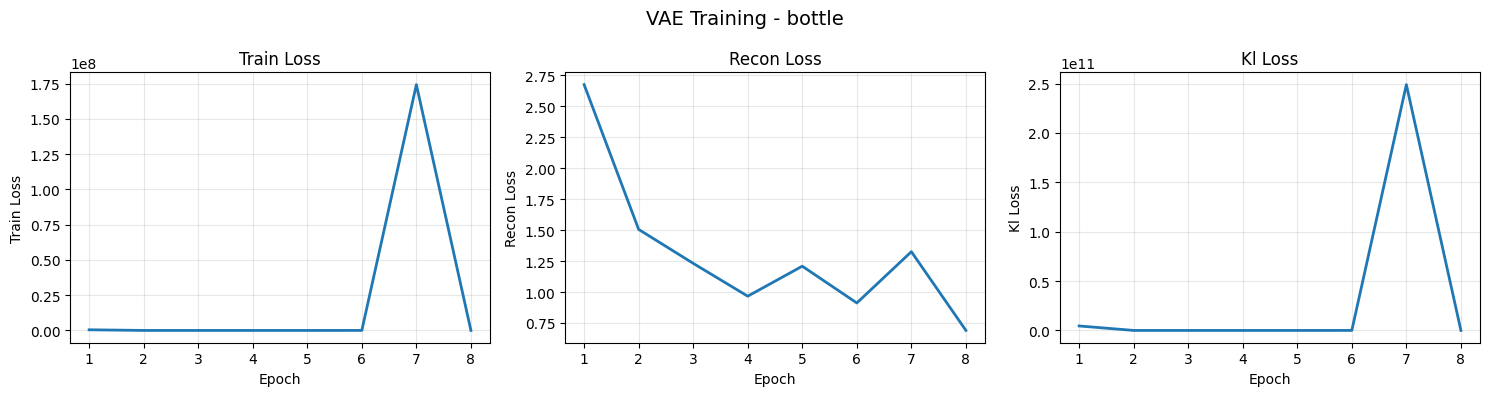


Training VAE: CABLE


cable:  12%|█▏        | 6/50 [01:43<12:41, 17.30s/it]

Early stopping at epoch 7


CABLE ROC-AUC: 0.4025


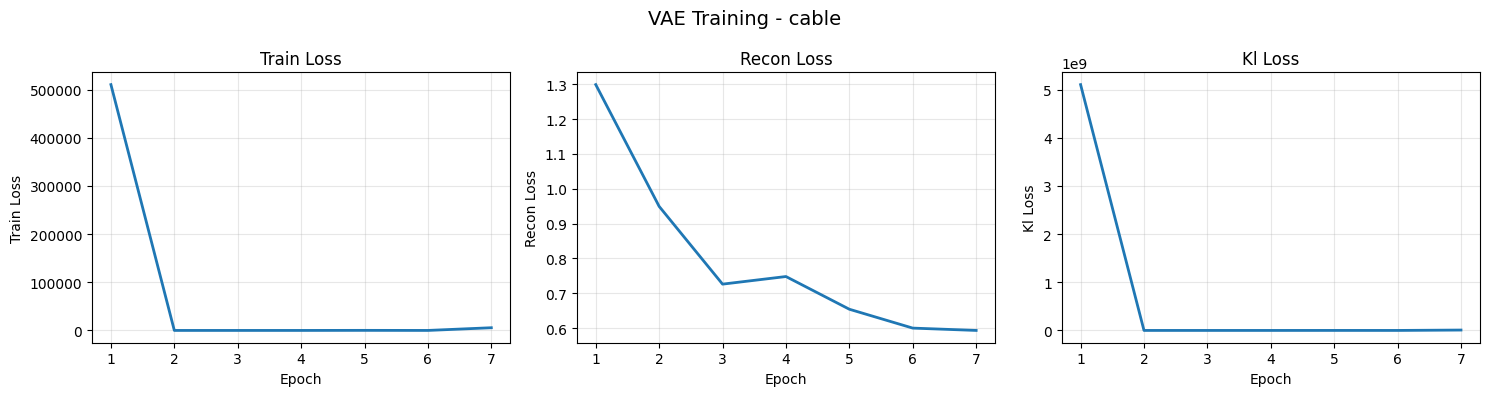


Training VAE: CAPSULE


capsule:  56%|█████▌    | 28/50 [06:47<05:20, 14.56s/it]

Early stopping at epoch 29


CAPSULE ROC-AUC: 0.5895


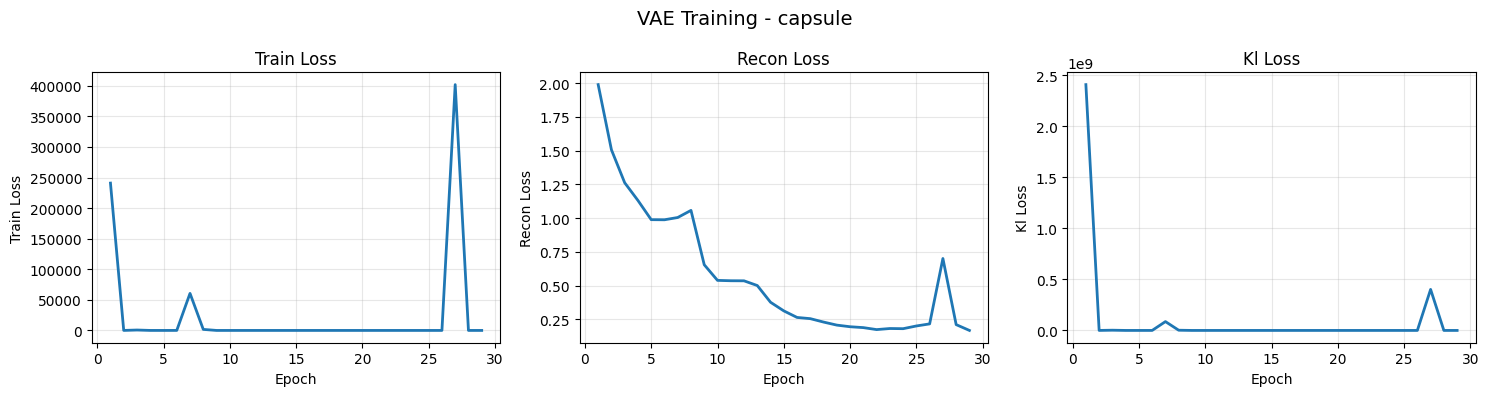


Training VAE: CARPET


carpet:  12%|█▏        | 6/50 [02:05<15:22, 20.97s/it]

Early stopping at epoch 7


CARPET ROC-AUC: 0.2504


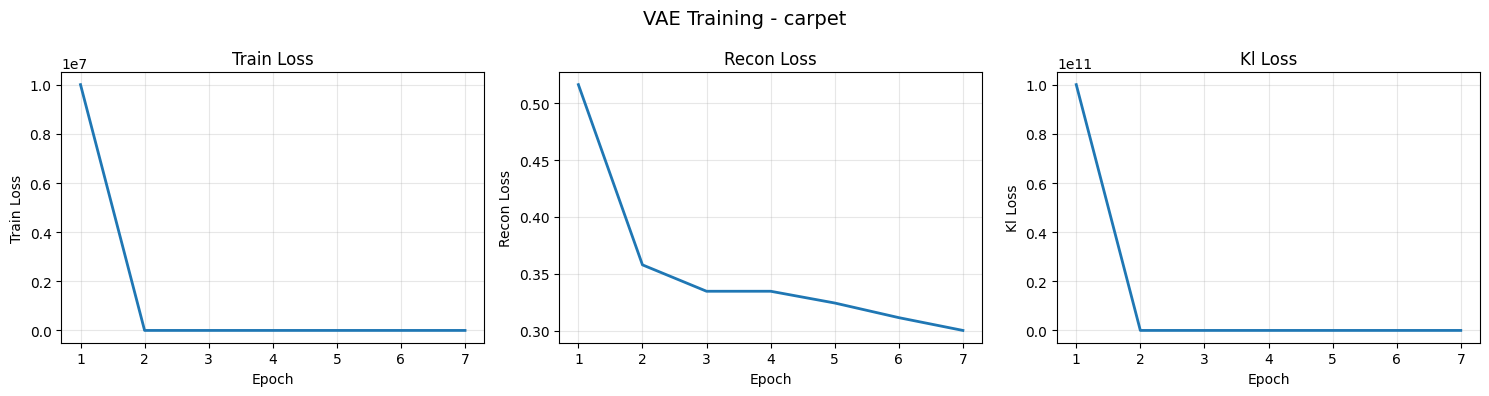


Training VAE: GRID


grid:  12%|█▏        | 6/50 [01:32<11:15, 15.35s/it]

Early stopping at epoch 7


GRID ROC-AUC: 0.4996


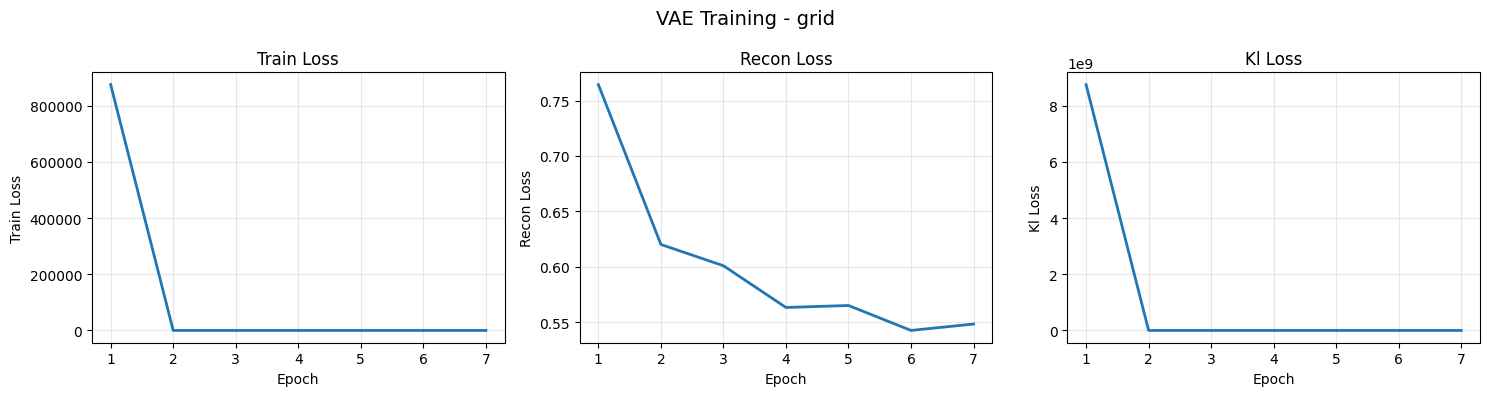


Training VAE: HAZELNUT


hazelnut:  12%|█▏        | 6/50 [03:02<22:15, 30.36s/it]

Early stopping at epoch 7


HAZELNUT ROC-AUC: 0.3261


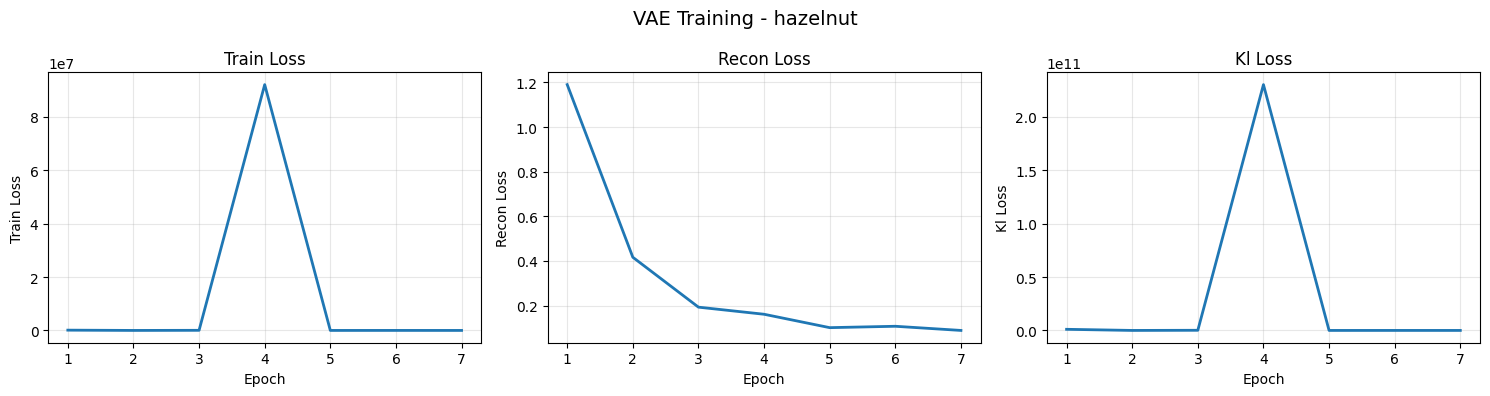


Training VAE: LEATHER


leather:  12%|█▏        | 6/50 [01:44<12:49, 17.49s/it]

Early stopping at epoch 7


LEATHER ROC-AUC: 0.2385


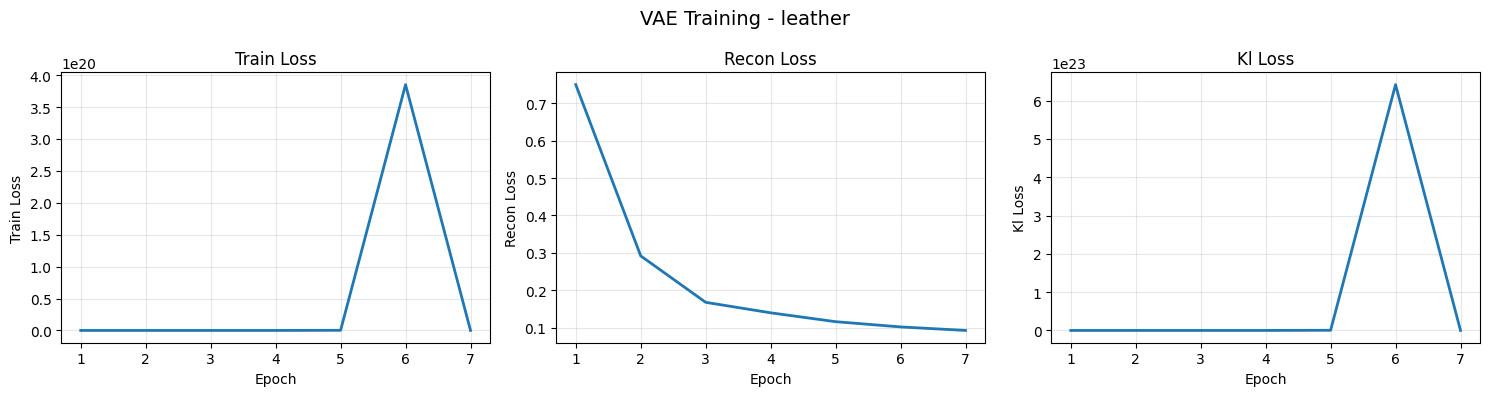


Training VAE: METAL_NUT


metal_nut:  12%|█▏        | 6/50 [01:13<08:58, 12.24s/it]

Early stopping at epoch 7


METAL_NUT ROC-AUC: 0.6725


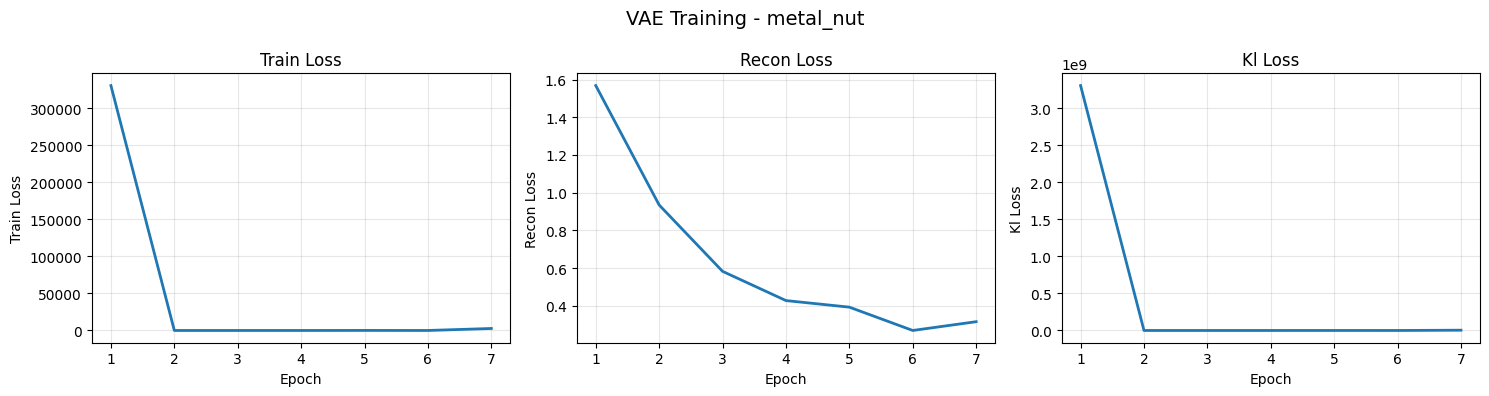


Training VAE: PILL


pill:  12%|█▏        | 6/50 [01:39<12:11, 16.62s/it]

Early stopping at epoch 7


PILL ROC-AUC: 0.4081


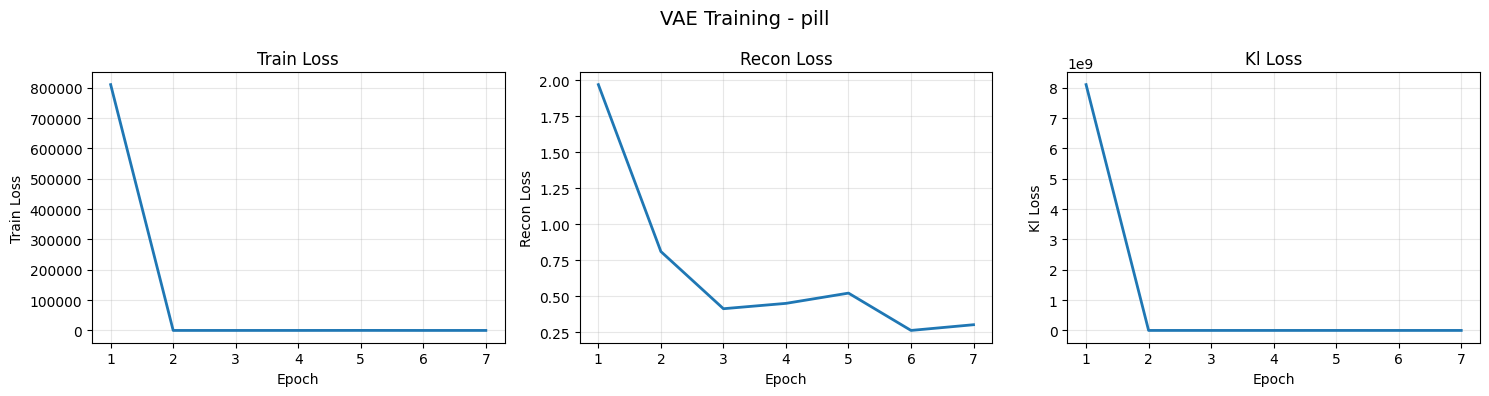


Training VAE: SCREW


screw:  22%|██▏       | 11/50 [03:09<11:12, 17.23s/it]

Early stopping at epoch 12


SCREW ROC-AUC: 1.0000


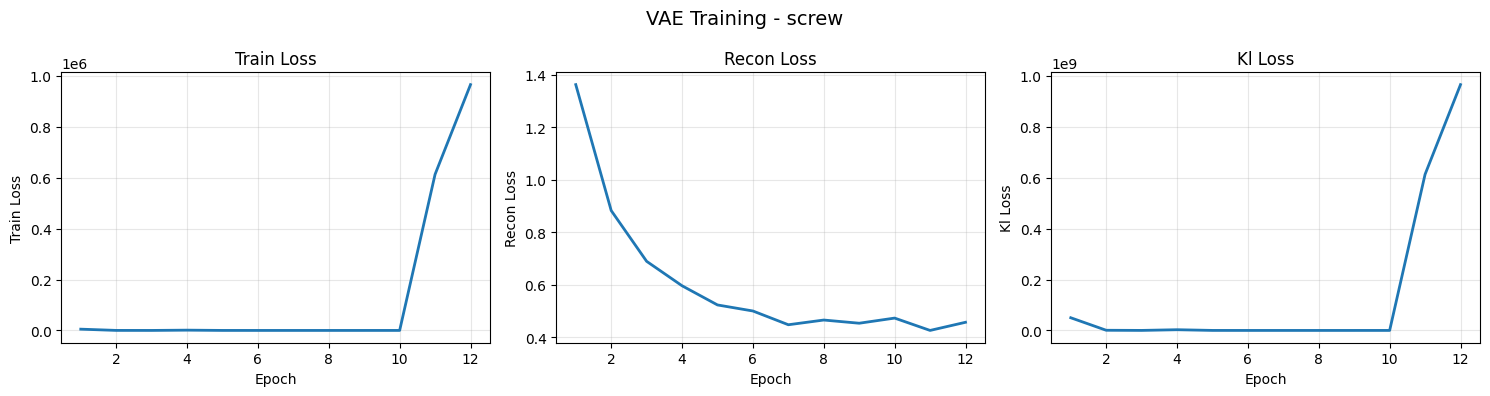


Training VAE: TILE


tile:  12%|█▏        | 6/50 [01:31<11:12, 15.27s/it]

Early stopping at epoch 7


TILE ROC-AUC: 0.3882


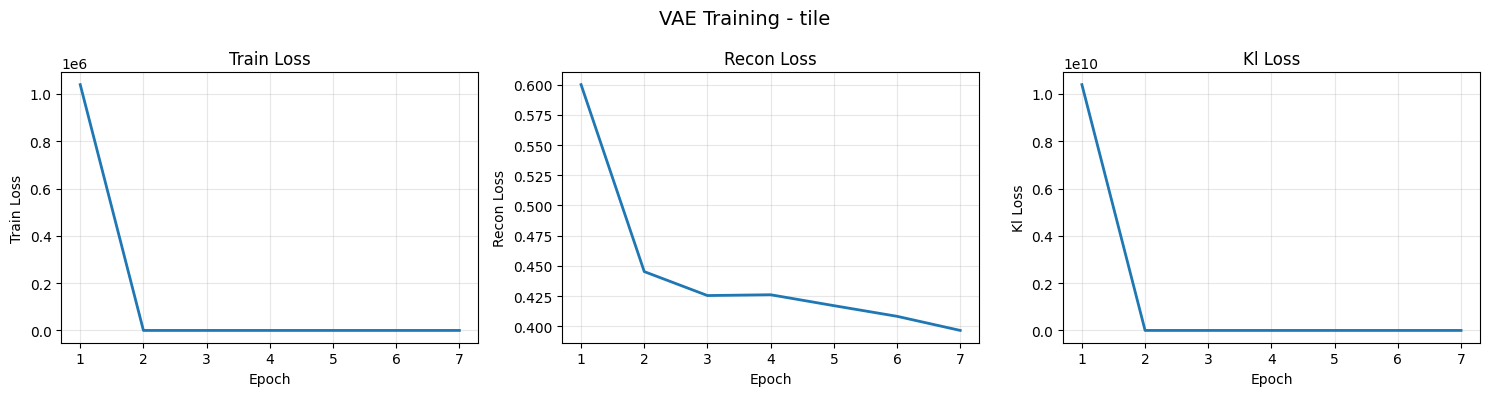


Training VAE: TOOTHBRUSH


toothbrush:  14%|█▍        | 7/50 [00:30<03:09,  4.40s/it]

Early stopping at epoch 8


TOOTHBRUSH ROC-AUC: 0.7111


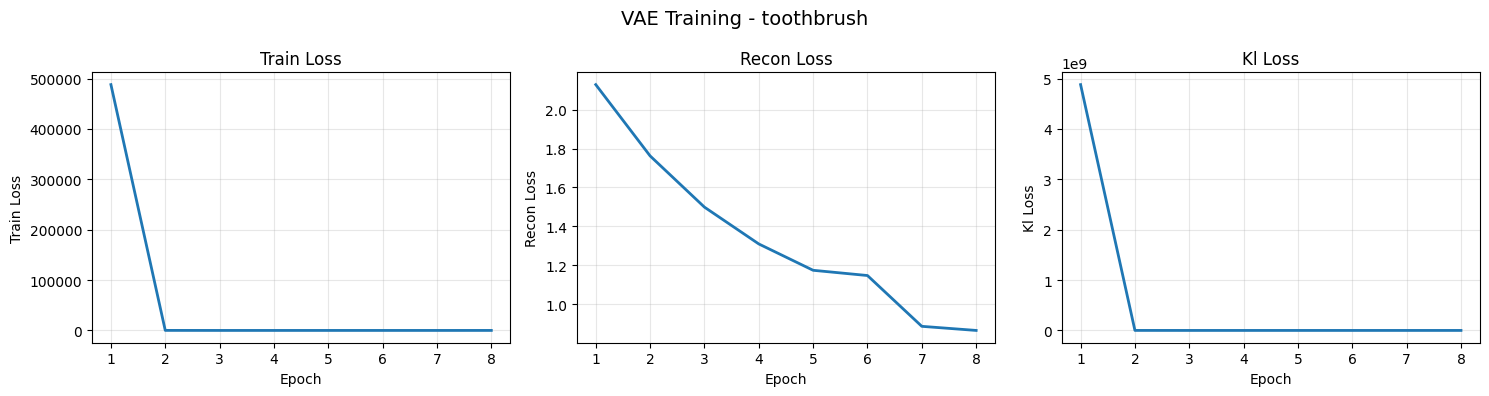


Training VAE: TRANSISTOR


transistor:  12%|█▏        | 6/50 [01:39<12:06, 16.52s/it]

Early stopping at epoch 7


TRANSISTOR ROC-AUC: 0.4004


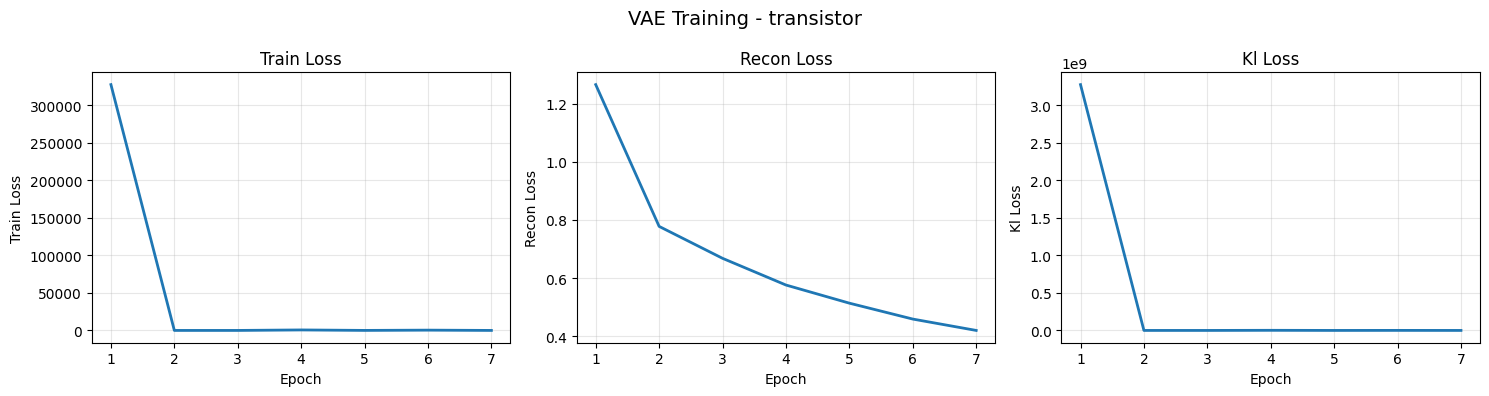


Training VAE: WOOD


wood:  12%|█▏        | 6/50 [01:54<14:01, 19.13s/it]

Early stopping at epoch 7


WOOD ROC-AUC: 0.3596


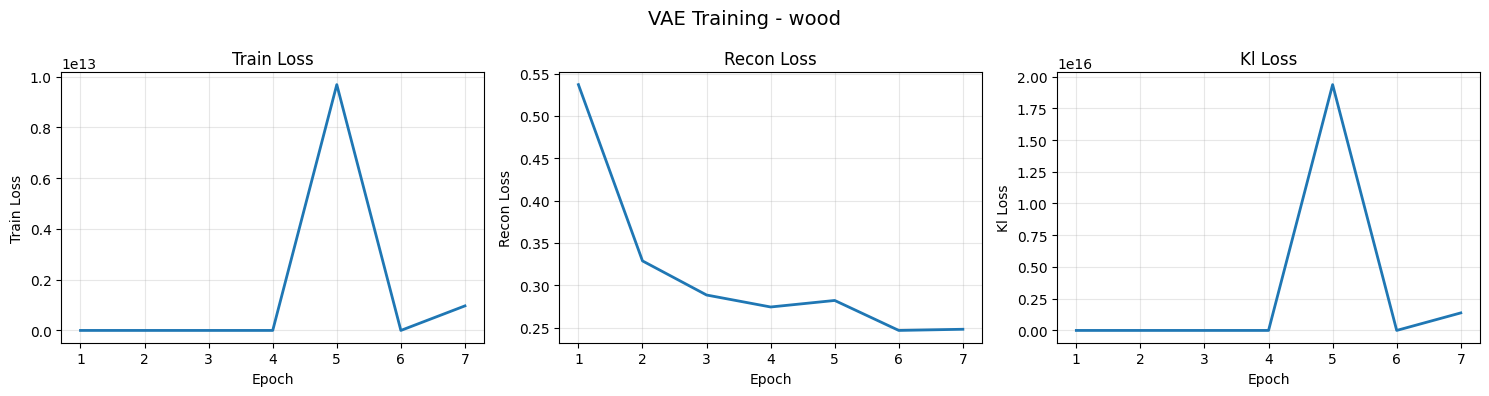


Training VAE: ZIPPER


zipper:  12%|█▏        | 6/50 [01:20<09:51, 13.45s/it]

Early stopping at epoch 7


ZIPPER ROC-AUC: 0.4414


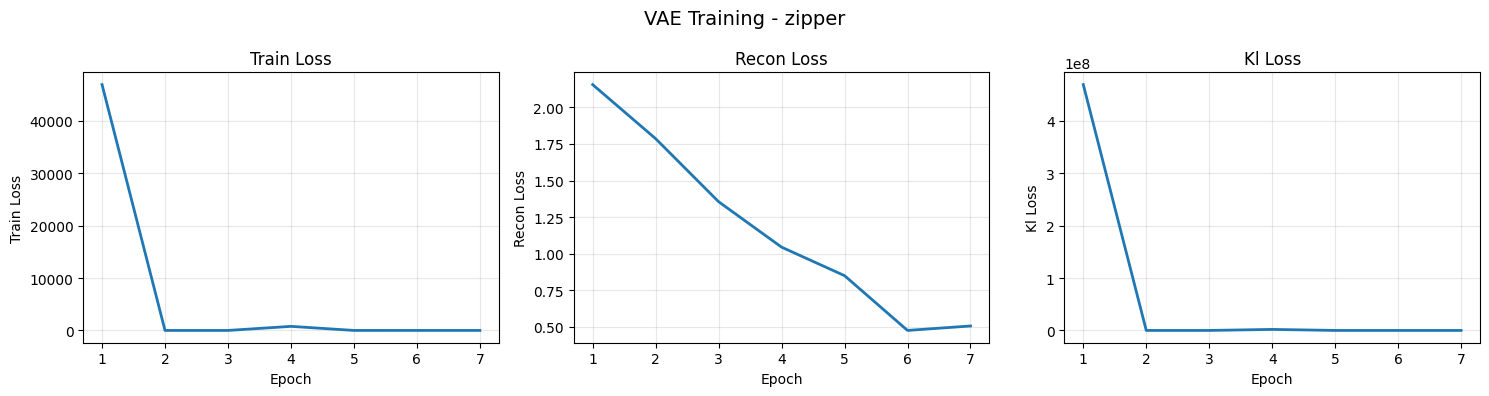


=== VAE Results ===


,category,auc,final_loss
0,bottle,0.457143,1.861612e+02
1,cable,0.402549,5.601574e+03
2,capsule,0.589549,4.321262e+00
3,carpet,0.250401,4.714055e+00
4,grid,0.499582,7.839554e+00
5,hazelnut,0.326071,1.448758e+01
6,leather,0.238451,1.613815e+12
7,metal_nut,0.672532,2.700161e+03
8,pill,0.408074,3.507515e+00
9,screw,1.000000,9.658341e+05


In [ ]:
results = []

for category in CATEGORIES_TO_TRAIN:
    res = train_vae_category(category)
    if res:
        results.append(res)

# Summary
df_results = pd.DataFrame(results)
if not df_results.empty:
    print("\n=== VAE Results ===")
    display(df_results)
    df_results.to_csv(OUTPUTS_DIR / 'vae_mvtec_results.csv', index=False)